# <div align="center">Level 1. Titanic: Machine Learning form Disaster</div>
## <div align="center">3. Titanic Top 4% with ensemble modeling</div>
### <div align="center"> 제작자 : 김규동 </div>
### <div align="center"> 제작 시작 : 2020. 1. 14. 20:00 PM <br> 최종 수정 : 2019. 1. 15. 00:30 AM</div>

-----------------------------------------------------------------------------------------------------------
<a id="0"></a> <br>
# 목차
1. [소개](#1)
<br><br>
1. [데이터 불러오기 및 확인](#2)
    1. [데이터 불러오기](#2)
    1. [이상 탐지](#3)
    1. [훈련 데이터 및 테스트 데이터 붙이기](#4)
    1. [결측값 및 Null값 찾아내기](#5)
<br><br>
1. [변수 분석](#6)
    1. [수치값 분석](#6)
    1. [카테고리값 분석](#7)
<br><br>
1. [결측치 채우기](#8)
    1. [Age](#8)
<br><br>
1. [Feature engineering](#9)
    1. [Name/Title](#9)
    1. [Family Size](#10)
    1. [Cabin](#11)
    1. [Ticket](#12)
<br><br>
1. [모델 생성](#13)
    1. [Simple modeling](#14)
        * [6.1.1 교차 검증 모델](#14)
        * [6.1.2 최고의 모델에 대한 하이퍼파라미터 튜닝](#15)
        * [6.1.3 Plot learning curves](#16)
        * [6.1.4 Feature importance of the tree based classifiers](#17)
    1. [Ensemble modeling](#18)
        * [6.2.1 Combining models](#18)
    1. [Prediction](#19)
        * [6.3.1 Predict and Submit results](#19)

In [1]:
# 시작 전, 패키지 임포트

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

import warnings
warnings.filterwarnings(action='ignore')

[목차로](#0)

------------------------------------------------------------------------------------------------
<a id="1"></a> <br>
# 1. 소개

Yassine Ghouzam, PhD가 처음 작성하는 커널이며, 본인이 3번째 번역한 커널입니다.<br>
저자는 feature engineering과 ensemble modeling을 소개하는 좋은 방법인 타이타닉 대회를 선택했습니다.<br>
먼저, feature engineering에 잘못 초점을 맞춘 몇 가지 feature analysis를 표시할 것입니다. 마지막 부분은 투표 절차를 이용하여 타이타닉의 생존을 모델링하고 예측하는 것에 관한 것입니다.

이 스크립트는 세 가지 주요 부분을 따릅니다.

- feature analysis
- feature engineering
- modeling

[목차로](#0)

------------------------------------------------------------------------------------------------
<a id="2"></a> <br>
## 2. 데이터 불러오기 및 확인

### 2.1 데이터 불러오기

In [2]:
# 데이터 불러오기
##### 훈련 데이터 및 테스트 데이터 불러오기

train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
IDtest = test["PassengerId"]

In [3]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
IDtest.head(5)

0    892
1    893
2    894
3    895
4    896
Name: PassengerId, dtype: int64

[목차로](#0)
<a id="3"></a> <br>
### 2.2 이상 탐지

In [6]:
# 이상 탐지를 위한 함수 작성

def detect_outliers(df,n,features):
    """
    데이터프레임 df를 취하고
    Tukey 방법에 따라 n개 이상의 특이치를 포함하는
    관측치에 해당하는 지수 목록을 반환하는 함수
    """
    outlier_indices = []
    
    # features(columns) 반복
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # col에 대한 특이치 리스트 결정
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # 발견된 특이값 색인을 특이값 목록에 추가 
        outlier_indices.extend(outlier_list_col)
        
    # 두 개 이상의 특이치를 포함하는 관측치 선택
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

In [7]:
# Age, SibSp , Parch, Fare에 대한 이상값 탐지
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])
Outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

특이치는 예측에 극적인 영향을 미칠 수 있기 때문에(특히 회귀 문제에 대해) 저자는 이를 관리하기 위해 선택했습니다.

저자는 분배 값(IQR)의 1분위와 3분위수 사이에 구성된 사분위간 범위를 정의하는 outlier를 검출하기 위해 Tukey 방법(Tukey JW, 1977)을 사용했습니다.<br>
특이치란 형상 값이 특이치 스텝(IQR +- 특이치 스텝) 외부에 있는 행입니다.

저자는 숫자 값의 특징(Age, SibSp, Sarch, Fare)에서 특이치를 검출하기로 결정했습니다.<br>그리고 특이치를 최소 두 개의 돌출된 숫자 값을 가진 행으로 간주했습니다.

In [8]:
# Show the outliers rows
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


총 10개의 이상치를 탐지했습니다.

28, 89, 342번의 탑승객들이 높은 티켓 값을 가지고 있으며, 나머지 7명의 탑승객은 매우 높은 값의 SibSp를 가집니다.

In [9]:
# 이상값 제거
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

[목차로](#0)
<a id="4"></a> <br>
### 2.3 훈련 데이터와 테스트 데이터 붙이기

In [10]:
## 범주형 변환 중에 동일한 수의 feature를 얻기 위해 훈련 데이터와 테스트 데이터를 붙입니다.

train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

[목차로](#0)
<a id="5"></a> <br>
### 2.4 결측값 및 Null값 찾아내기

In [11]:
# NaN 값 및 결측 값에 NaN으로 채웁니다.
dataset = dataset.fillna(np.nan)

# Null값을 확인합니다.
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

Age와 Cabin은 누락된 값의 중요한 부분을 가지고 있습니다.

**생존 누락 값은 결합 테스트 데이터 세트에 해당됨(생존 열은 테스트 데이터에 존재하지 않으며, 훈련 및 테스트 데이터를 연결할 때 NaN 값으로 대체됨)**

In [12]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [13]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [14]:
### 데이터 요약
# 데이터 요약 및 통계를 확인합니다.
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


[목차로](#0)

------------------------------------------------------------------------------------------------
<a id="6"></a> <br>
## 3. 변수 분석
### 3.1 수치값 분석

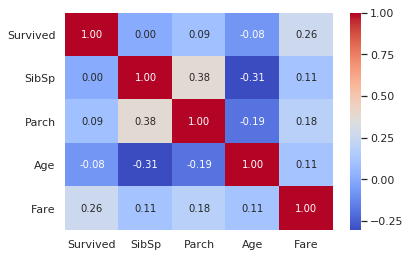

In [15]:
# 수치 값(SibSp, Parch, Age, Fare)과 Survived 값 사이의 상관 행렬
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

Fare만이 생존 확률과 의미 있는 상관관계가 있는 것 같습니다.

이는 다른 특징들이 완전하지 않다는 것을 의미하지는 않습니다.<br>
이러한 특징의 하위 집단은 생존과 연관될 수 있습니다. 이것을 결정하기 위해, 우리는 이 특징들을 자세히 탐구할 필요가 있습니다.

- SibSp

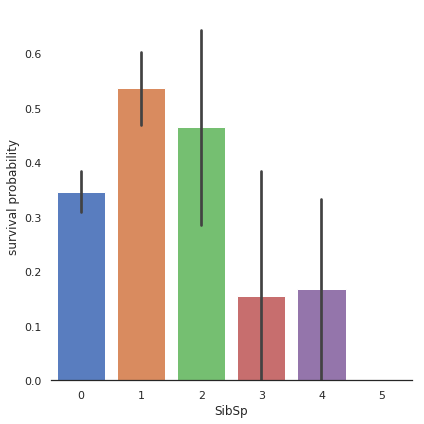

In [16]:
# SibSp vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

형제자매가 많은 승객들은 생존할 기회가 적은 것 같습니다.

1인승(SibSp : 0) 또는 2인승(SibSp : 1 or 2)이 생존할 수 있는 기회가 더 많은 것을 볼 수 있습니다.

이 관찰은 매우 흥미로운데, 우리는 이러한 범주를 설명하는 새로운 특징을 고려할 수 있습니다.

- Parch

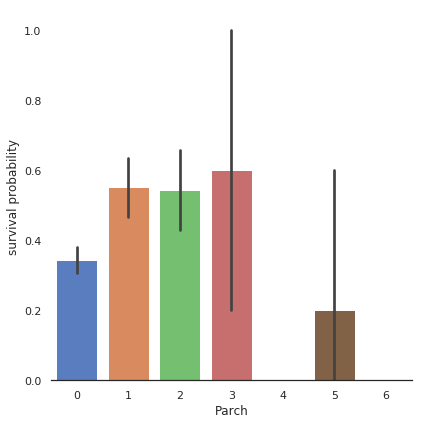

In [17]:
# Parch vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

소가족은 단일(Parch : 0), 중간(Parch : 3 or 4) 및 대가족(Parch : 5 or 6)보다 생존할 기회가 더 많은 것을 알 수 있습니다.

3명의 부모/자녀가 있는 승객의 생존에 중요한 표준 편차가 있음을 주의해야 합니다.

- Age

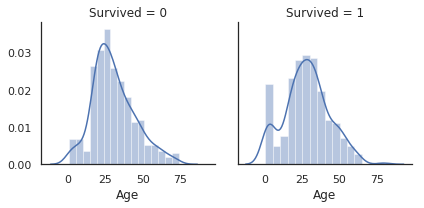

In [18]:
# Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

Age 분포는 꼬리를 가진 분포, 어쩌면 가우스 분포인 것 같습니다.

우리는 Age 분포가 생존 인구에서 같지 않고 생존 하위 인구에서도 동일하지 않다는 것을 알아챘습니다. 실제로, 젊은 승객들에 대한 봉우리가 있는데, 이들은 살아남았습니다. 또한 60-80세 사이의 승객들이 덜 살아남았다는 것을 볼 수 있습니다.

따라서, "Age"가 "Survived"와 상관관계가 없다고 해도, 생존할 기회가 거의 없는 승객의 연령 범주가 있음을 알 수 있습니다.

별도로 아주 어린 승객들이 생존할 기회가 더 많은 것 같습니다.

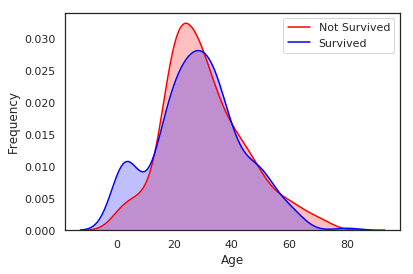

In [19]:
# Age 분포 보기
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

두 분포를 겹쳐 볼 때, 우리는 영유아들(Age : 0 ~ 5)의 봉우리가 서로 연결되어 있는 것을 볼 수 있습니다.

- Fare

In [20]:
dataset["Fare"].isnull().sum()

1

In [21]:
# Fare 값에 빈 값은 중앙값으로 채웁니다.
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

하나의 누락된 값을 가지고 있기 때문에, 저자는 이를 예측에 중요한 영향을 미치지 않는 중앙값으로 채우기로 결정했습니다.

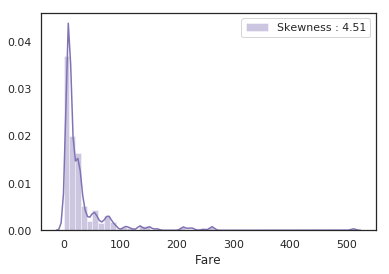

In [22]:
# Fare 분포 보기
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

요금 분포는 매우 왜곡되어 있습니다. 크기를 조정하더라도 모델에서 매우 높은 값을 초과할 수 있습니다.

이 경우, 로그 기능으로 변환하여 이 왜도를 줄이는 것이 좋습니다.

In [23]:
# 분포의 왜곡을 줄이기 위해 Fare 값에 대해 로그 변환을 시행합니다.
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

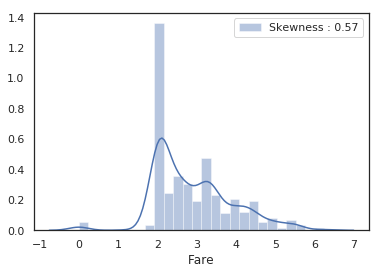

In [24]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

로그 변환 후 왜도가 확실히 감소되었습니다.

[목차로](#0)
<a id="7"></a> <br>
### 3.2 카테고리 값 분석
- Sex

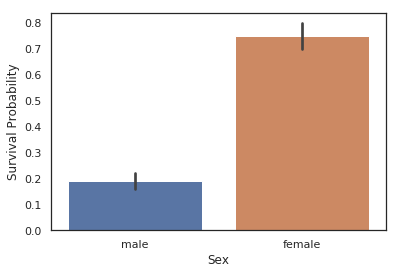

In [25]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [26]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


남자가 여자보다 생존할 기회가 적다는 것은 명백해 보입니다.<br>
그래서 Sex는 생존을 예측하는 데 중요한 역할을 할지도 모릅니다.

타이타닉 영화(1997년)를 본 사람들이라면 이 문장을 기억할 것입니다.

"여자와 아이들 먼저!"

- Pclass

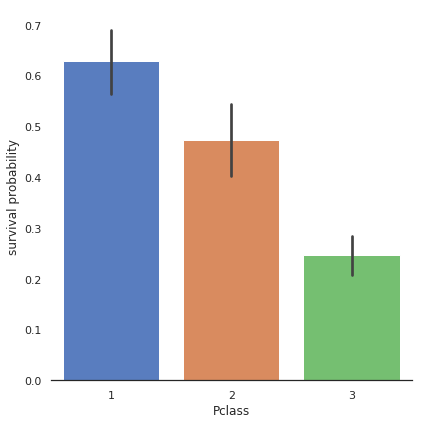

In [27]:
# Pclass vs Survived
g = sns.factorplot(x="Pclass",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

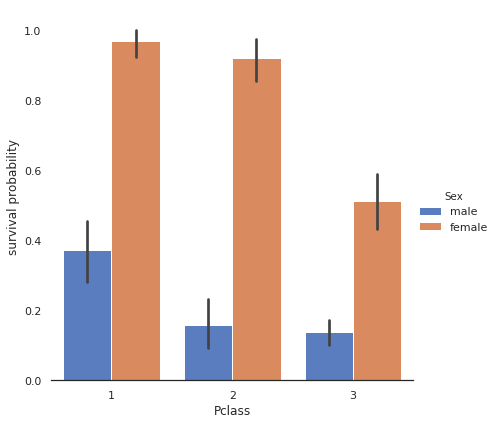

In [28]:
# Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

승객 생존은 3개 등급에서 같지 않습니다. 일등석 승객은 이등석, 삼등석 승객보다 생존할 기회가 더 많습니다.

이러한 경향은 우리가 남녀 승객 모두에 해당합니다.

- Embarked

In [29]:
dataset["Embarked"].isnull().sum()

2

In [30]:
# Embarked의 최빈값인 'S'로 NaN 값을 채웁니다.
dataset["Embarked"] = dataset["Embarked"].fillna("S")

두 개의 누락된 값을 가지고 있기 때문에, Embarked의 최빈값인 'S'를 채우기로 결정했습니다.

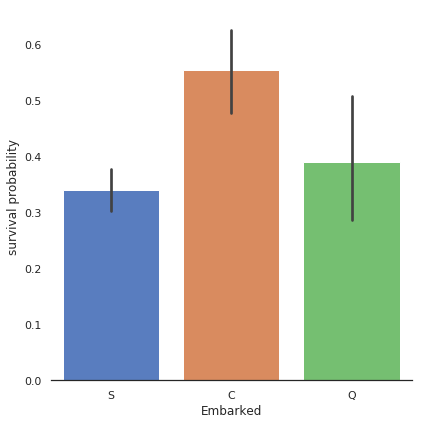

In [31]:
# Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

체르부르(Cherbourg)에서 오는 승객은 생존할 기회가 더 많은 것 같습니다.

저자 생각에, 1등 승객의 비율이 퀸스타운(Q), 사우샘프턴(S)보다 체르부르(C)에서 온 승객의 비율이 더 높다는 것입니다.

Pclass와 Embarked의 분포를 봅시다.

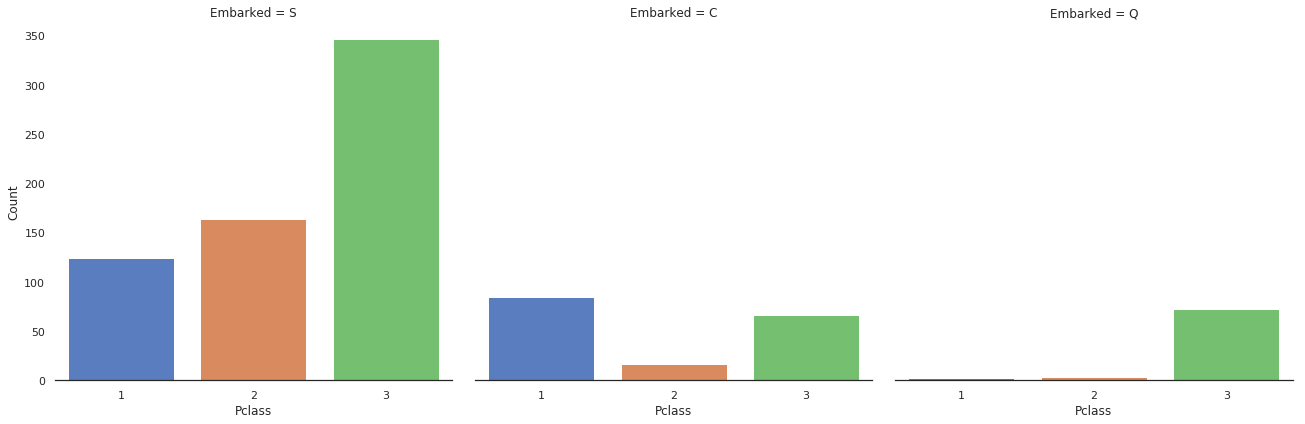

In [32]:
# Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

실제로 3등석은 사우샘프턴(S)과 퀸스타운(Q)에서 오는 승객이 가장 많은 반면, 체르부르크 승객은 생존율이 가장 높은 1등석에 있습니다.

이쯤 되면 일등석의 생존율이 높은 이유를 설명할 수 없습니다.

저자는 일등석 승객들이 그들의 영향력으로 인해, 대피하는 동안 우선순위를 정했다고 생각합니다.

[목차로](#0)

------------------------------------------------------------------------------------------------
<a id="8"></a> <br>
## 4. 결측치 채우기
### 4.1 Age

Age 열에는 전체 데이터셋 중 256개의 결측값이 포함되어 있습니다.

생존 가능성이 더 많은 하위 인구(예를 들어 어린이)가 있기 때문에,<br>
연령 특성을 유지하고 누락된 값을 귀속시키는 것이 바람직합니다.

이 문제를 해결하기 위해, 저자는 Age와 가장 상관관계가 있는 변수들(Sex, Parch , Pclass, SibSP)을 살펴보았습니다.

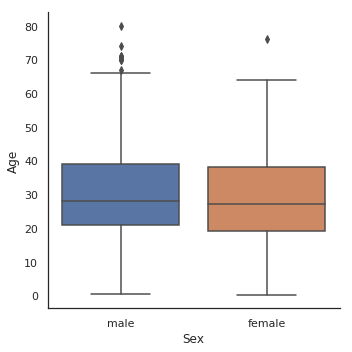

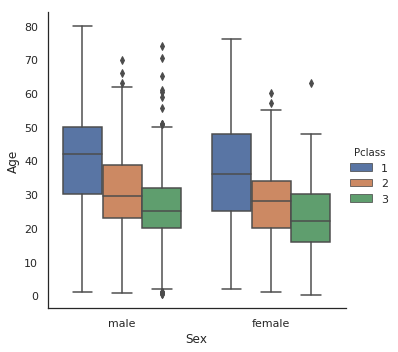

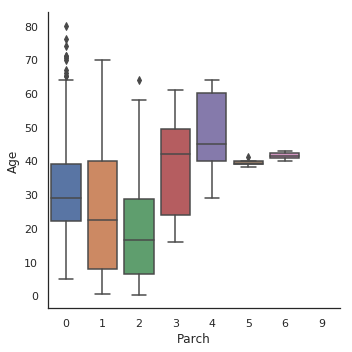

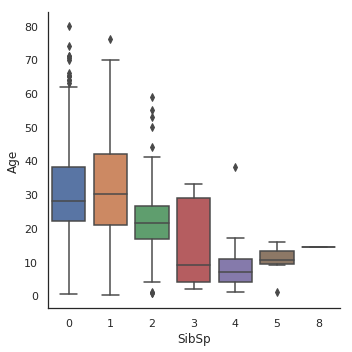

In [33]:
# Age vs Sex, Parch, Pclass, SibSp
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

Age 분포는 남성과 여성의 하위 모집단에서 동일한 것으로 보여, Sex가 Age를 예측하는 데 유용하지 않아 보입니다.

그러나 1등 승객은 3등 승객보다 나이가 많은 2등 승객보다도 나이가 많습니다.

게다가, 나이가 많을수록 부모/자식이 많고, 형제/자매가 많을수록 젊다는 것을 알 수 있습니다.

In [34]:
# Sex에 대해, 남성의 경우 0, 여성의 경우 1의 범주형 값으로 변환합니다.
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

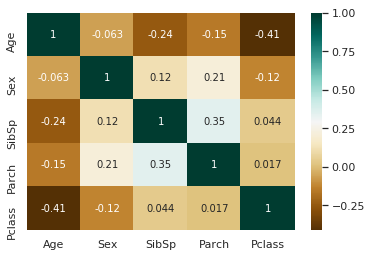

In [35]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

상관 관계 행렬은 Parch를 제외한 요인 그림 관측치를 확인합니다.

Age는 Sex와는 상관관계가 없지만 Pclass, Parch, SibSp 등과 음의 상관관계가 있습니다.

Parch에서의 Age 그래프에서, 나이는 부모/자식의 수에 따라 성장하고 있음을 알 수 있습니다. 하지만 일반적으로 음의 상관관계에 있습니다.

그래서 저자는 Age의 결측값을 채우기 위해 SibSP, Parch, Pclass를 사용하기로 합니다.<br>
Pclass, Parch, Sibsp에 따라 Age를 유사한 행의 중위 연령으로 채우는 전략입니다.

In [36]:
# Age의 결측값 채우기

## Pclass, Parch, Sibsp에 따라 Age를 유사한 행의 중위 연령으로 채웁니다.
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

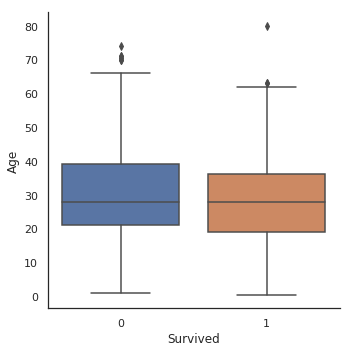

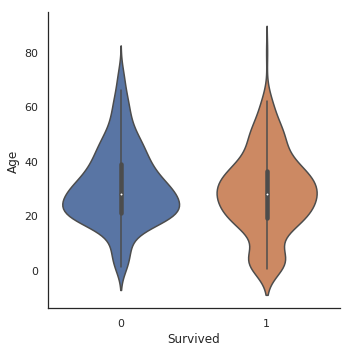

In [37]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

생존한 연령의 중간값과 하위 인구에서 살아남지 못한 연령의 차이는 없습니다.

하지만 살아남은 승객들의 바이올린 그래프를 통해, 여전히 매우 어린 승객들이 생존율이 높다는 것을 알아낼 수 있습니다.

[목차로](#0)

------------------------------------------------------------------------------------------------
<a id="9"></a> <br>
## 5. Feature engineering
### 5.1 Name/Title

In [38]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Name에는 승객의 제목에 대한 정보가 포함되어 있습니다.

대피 중에는 직함이 별도로 존재하는 승객을 선호할 수 있으므로 모델에 추가하는 것이 좋아 보입니다.

In [39]:
# Name으로부터 Title 뽑아내기
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

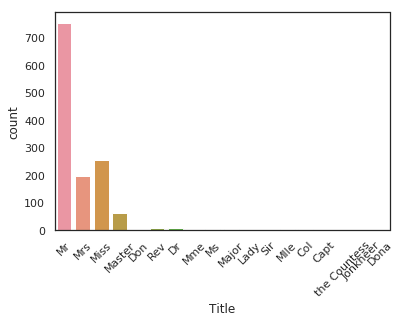

In [40]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

데이터셋에는 17개의 Title이 있는데, 대부분은 매우 드물며 우리는 4개의 범주로 분류할 수 있습니다.

In [41]:
# Title을 범주형 값으로 분류하기 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

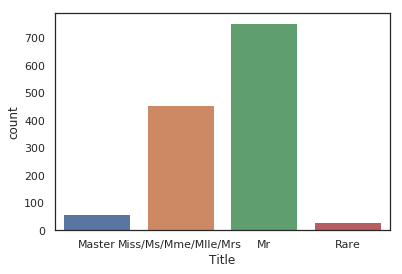

In [42]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

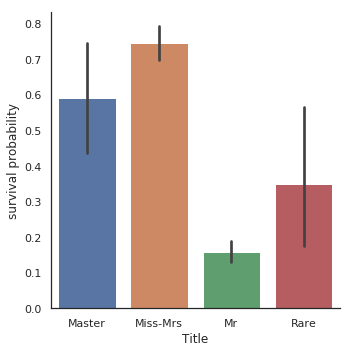

In [43]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

"여자와 아이 먼저!" 

희귀한 직함을 가진 승객들이 생존할 기회가 더 많다는 것은 흥미롭습니다.

In [44]:
# Name 변수 제거
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

[목차로](#0)
<a id="10"></a> <br>
### 5.2 Family size

대가족이 대피하는 동안 자매/형제/부모들을 찾아 대피하는 데 더 많은 어려움을 겪을 것이라고 상상할 수 있습니다.<br>
그래서 SibSp+Parch+1(승객 포함)을 의미하는 "Fsize"(Family size)을 만듭니다.

In [45]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

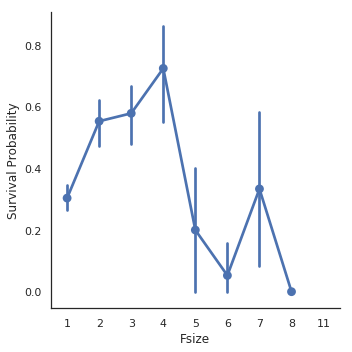

In [46]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

가족의 크기가 중요한 역할을 하는 것 같아 보입니다. 생존 확률은 대가족이 제일 작습니다.

저자는 가족 크기의 4가지 범주를 만들기로 결정합니다.

In [47]:
# family size의 4가지 범주 만들기
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

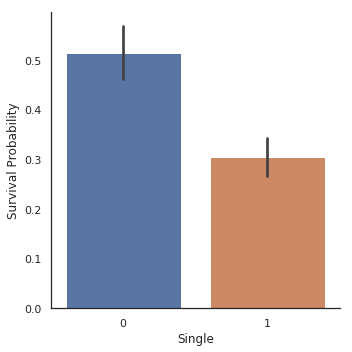

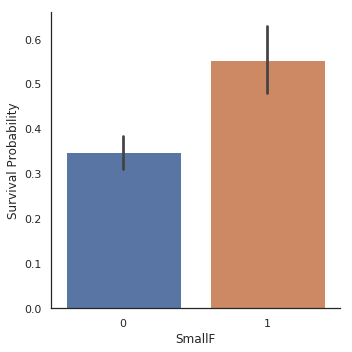

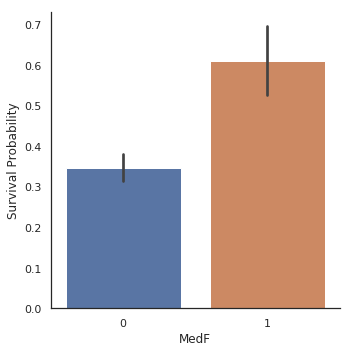

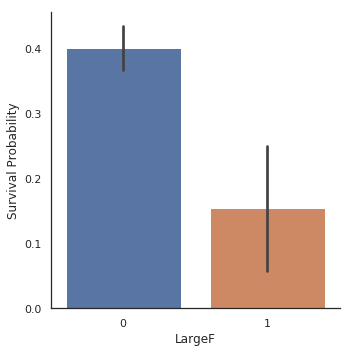

In [48]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

Family size의 요인 그림은 중소가족이 단일 승객이나 대가족보다 생존할 기회가 더 많다는 것을 보여줍니다.

In [49]:
# Title, Embarked에 대해 원핫 인코딩(One-Hot encoding) 실행 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [50]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,0,0,0,0,0,1,0,0,0,1


여기까지는 데이터셋에 22가지 변수가 있습니다.

[목차로](#0)
<a id="11"></a> <br>
### 5.3 Cabin

In [51]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [52]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [53]:
dataset["Cabin"].isnull().sum()

1007

Cabin 열에는 292개의 값과 1007개의 결측값이 포함되어 있습니다.

저자는 선실이 없는 승객들은 선실 번호 대신 누락된 값을 가지고 있다고 생각합니다.

In [54]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [55]:
# Cabin에서 결측값에는 'X'라고 표시
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

선실의 첫 번째 글자는 Desk를 가리키며, 나는 타이타닉에 탑승한 승객의 위치를 표시하기 때문에 이 정보만을 보관하도록 선택합니다.

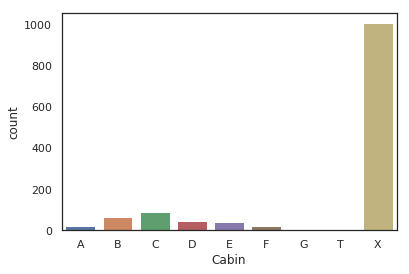

In [56]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

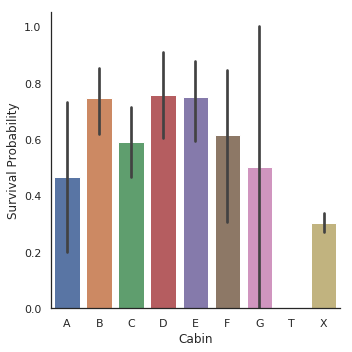

In [57]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

선실이 있는 승객의 수가 적기 때문에 생존 확률은 중요한 표준 편차를 가지고 있고, 우리는 다른 Desk에 있는 승객의 생존 확률을 구별할 수 없습니다.

그러나 우리는 선실을 가진 승객들이 선실이 없는(X) 승객들보다 일반적으로 생존할 기회가 더 많다는 것을 알 수 있습니다.(특히 B, C, D, E, F의 경우)

In [58]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

[목차로](#0)
<a id="12"></a> <br>
### 5.4 Ticket

In [59]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

같은 접두사를 공유하는 Ticket이 함께 배치될 수 있다는 것 같습니다. 이는 선박 내 선실들이 실제로 같이 배치되는 것으로 이어질 수 있다.

접두사가 같은 Ticket은 비슷한 등급과 생존을 가질 수 있습니다.

그래서 저자는 Ticket 열을 접두사만 뽑아 바꾸기로 했고, 그게 더 유익할지도 모른다고 생각합니다.

In [60]:
## Ticket에서 접두사를 추출(접두사가 없으면 X를 반환)

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [61]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [62]:
# Pclass에 대해 카테고리화
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [63]:
# 쓸모없는 변수 제거 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [64]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


[목차로](#0)

------------------------------------------------------------------------------------------------
<a id="13"></a> <br>
## 6. MODELING

In [65]:
## 훈련 데이터와 테스트 데이터 분리

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

In [66]:
## 훈련 데이터에서 라벨 분리

train["Survived"] = train["Survived"].astype(int)
Y_train = train["Survived"]
X_train = train.drop(labels = ["Survived"],axis = 1)

[목차로](#0)
<a id="14"></a> <br>
### 6.1 Simple modeling
#### 6.1.1 교차 검증 모델

저자는 10개의 인기 분류기를 비교하고 층화된 k폴드 교차 검증 절차에 의해 각각의 평균 정확도를 평가하였습니다.

* SVC
* Decision Tree(의사결정나무)
* AdaBoost 
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression(로지스틱 회귀)
* Linear Discriminant Analysis

여기부터는 저자의 결과와 본인의 결과가 다르게 나올 수 있습니다.

In [67]:
# K-fold 교차검증 모델 작성
kfold = StratifiedKFold(n_splits=10)

In [68]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [69]:
# n_jobs = 2일 때
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=2))
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res_2 = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})
cv_res_2

,CrossValMeans,CrossValerrors,Algorithm
0,0.822944,0.045155,SVC
1,0.795774,0.039714,DecisionTree
2,0.803728,0.052303,AdaBoost
3,0.814977,0.035252,RandomForest
4,0.807035,0.036652,ExtraTrees
5,0.829724,0.041959,GradientBoosting
6,0.808172,0.038518,MultipleLayerPerceptron
7,0.795710,0.040837,KNeighboors
8,0.822932,0.033765,LogisticRegression
9,0.822932,0.038751,LinearDiscriminantAnalysis


In [70]:
# n_jobs = 4일 때
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res_4 = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})
cv_res_4

,CrossValMeans,CrossValerrors,Algorithm
0,0.822944,0.045155,SVC
1,0.795774,0.039714,DecisionTree
2,0.803728,0.052303,AdaBoost
3,0.814977,0.035252,RandomForest
4,0.807035,0.036652,ExtraTrees
5,0.829724,0.041959,GradientBoosting
6,0.808172,0.038518,MultipleLayerPerceptron
7,0.795710,0.040837,KNeighboors
8,0.822932,0.033765,LogisticRegression
9,0.822932,0.038751,LinearDiscriminantAnalysis


n_jobs 인수는 CPU 코어 수에 따라 속도가 바뀝니다.<br>
그런데 본인의 CPU 코어 수가 2라면 2에 맞추는 것보단 그냥 적절한 값인 4로 맞추는게 좋아보입니다.

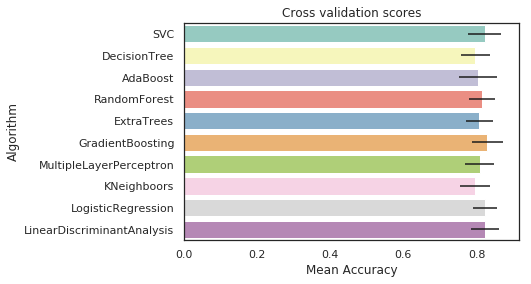

In [71]:
cv_res = cv_res_4
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

저자는 앙상블 모델링을 위해 SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting 분류기를 선택했습니다만,<br>
본인은 SVC, GradientBoosting, RandomForest, LogisticRegression, LinearDiscriminantAnalysis를 선택했습니다.

<a id="15"></a> <br>
#### 6.1.2 최고의 모델에 대한 하이퍼파라미터 튜닝

본인은 위 다섯 분류기에 대한 그리드 검색 최적화를 수행할 것입니다.(저자와의 비교도 할 것입니다.)

이때 "n_jobs" 매개 변수는 4로 설정할건데, 저자는 4개의 CPU를, 저는 2개의 CPU를 가지고 있기 때문입니다.
이를 적절히 조절하면 계산 시간이 분명히 단축될 것입니다.

하지만 이 단계는 시간이 오래 걸릴 수 있습니다. 저자는 총 4개의 cpu에 15분이 걸렸다고 합니다.

저자와 본인은 공통적으로 SVC, RandomForest, GradientBoosting이 있으며
저자는 ExtraTrees, AdaBoost / 본인은 LogisticRegression, LinearDiscriminantAnalysis를 별도로 선택합니다.

a. SVC<br>
b. Random Forest<br>
c. Gradient Boosting<br>
d-1. Extra Trees<br>
d-2. AdaBoost<br>
e-1. Logistic Regression<br>
e-2. Linear Discriminant Analysis

In [72]:
### a. SVC
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}
gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsSVMC.fit(X_train,Y_train)
SVMC_best = gsSVMC.best_estimator_
# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.5s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   43.2s finished


0.8331441543700341

In [73]:
### b. Random Forest 
RFC = RandomForestClassifier()
## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose = 1)
gsRFC.fit(X_train,Y_train)
RFC_best = gsRFC.best_estimator_
# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.5min finished


0.8354143019296254

In [74]:
### c. Gradient boosting
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1]}
gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsGBC.fit(X_train,Y_train)
GBC_best = gsGBC.best_estimator_
# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   32.1s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   49.7s finished


0.8331441543700341

In [75]:
### d-1. Extra Trees 
ExtC = ExtraTreesClassifier()
## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose = 1)
gsExtC.fit(X_train,Y_train)
ExtC_best = gsExtC.best_estimator_
# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   30.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.4min finished


0.8365493757094211

In [76]:
### d-2. Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}
gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsadaDTC.fit(X_train,Y_train)
ada_best = gsadaDTC.best_estimator_
# best score
gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    9.7s finished


0.8240635641316686

In [77]:
### e-1. Logistic Regression
LRC = LogisticRegression()
lr_param_grid = {'penalty': ['l1','l2'],
                 'C': np.logspace(0, 4, 10),
                 'solver' : ['liblinear']}
gsLRC = GridSearchCV(LRC, param_grid = lr_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsLRC.fit(X_train,Y_train)
gsLRC_best = gsLRC.best_estimator_
# Best score
gsLRC.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.2s finished


0.8286038592508513

##### e-2. Linear Discriminant Analysis
이에 대한 그리드 서치 방법은 찾을 수 없었다. 

본인 컴퓨터 기준으로 요약하자면,<br>
a. SVC : 0.8331441543700341, 약 46초 소요<br>
b. Random Forest : 0.8365493757094211, 약 1분 42초 소요<br>
c. Gradient Boosting : 0.8331441543700341, 약 51초 소요<br>
d-1. Extra Trees : 0.8308740068104427, 약 1분 30초 소요<br>
d-2. AdaBoost : 0.8240635641316686, 약 11초 소요<br>
e-1. Logistic Regression : 0.8286038592508513, 약 6초 소요<br>
e-2. Linear Discriminant Analysis : x

<a id="16"></a> <br>
#### 6.1.3 Plot learning curves

학습 곡선은 훈련 데이터에 대한 오버핏 효과와 훈련 크기가 정확도에 미치는 영향을 확인할 수 있는 좋은 방법입니다.

In [78]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """테스트 데이터 및 학습 데이터 곡선의 간단한 그래프 생성"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

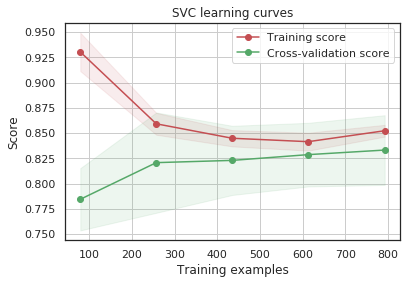

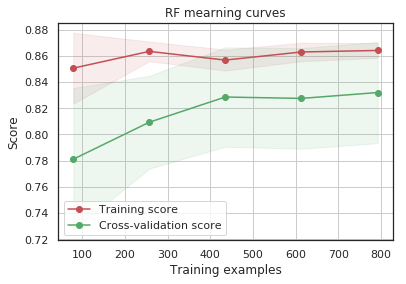

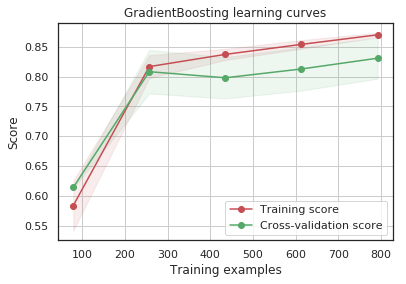

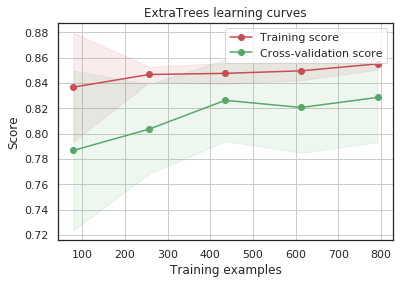

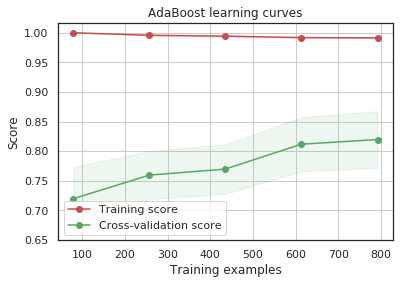

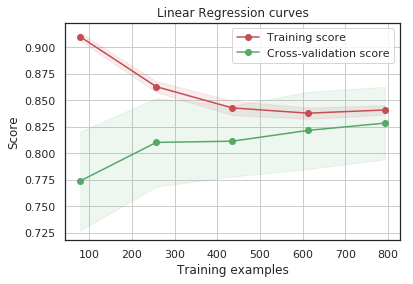

In [79]:
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsLRC.best_estimator_,"Linear Regression curves",X_train,Y_train,cv=kfold)

<저자 입장><br>
GradientBoosting과 Adaboost 분류기는 훈련 데이터에 지나치게 맞는 경향이 있습니다.<br>
교차 검증 곡선이 증가함에 따라 GradientBoosting과 Adaboost는 더 많은 훈련 데이터로 더 나은 성과를 낼 수 있습니다.<br>
SVC와 ExtraTree 분류기는 훈련 곡선과 교차 검증 곡선이 서로 가깝기 때문에 예측을 더 잘 일반화하는 것 같습니다.

<본인 입장><br>
GradientBoosting과 Extra Trees 분류기가 훈련 데이터에 지나치게 맞는 경향이 있습니다.<br>
교차 검증 곡선이 증가함에 따라 두 분류기는 더 많은 훈련 데이터로 더 나은 성과를 낼 수 있습니다.<br>
반면 Adaboost는 교차 검증 곡선과 훈련 곡선이 큰 차이를 보이고 있습니다.

<a id="17"></a> <br>
#### 6.1.4 Feature importance of tree based classifiers

승객 생존 예측을 위한 가장 유익한 기능을 보기 위해, 4개의 트리 기반 분류기에 대한 특징의 중요도을 표시합니다.

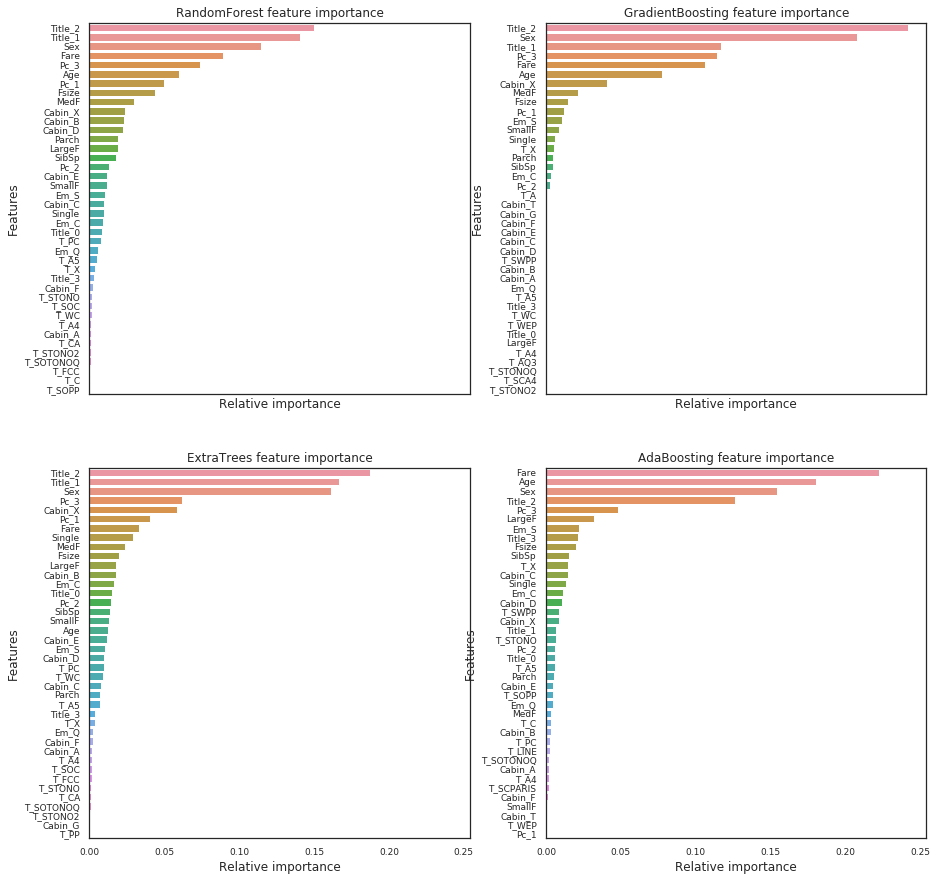

In [80]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))
names_classifiers = [("RandomForest",RFC_best),("GradientBoosting",GBC_best),
                     ("ExtraTrees",ExtC_best),("AdaBoosting",ada_best)]
nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

4개의 트리 기반 분류기(Adaboost, ExtraTree, RandomForest 및 GradientBoosting)에 대한 특징적 중요도를 표시했습니다.

우리는 이 네 가지 분류기가 상대적 중요도에 따라 상이한 최상위 특징을 가지고 있다는 점에 주목해야 합니다.<br>
그들의 예측이 같은 특징에 근거하지 않는다는 뜻입니다. 그럼에도 불구하고, 그들은 분류를 위한 몇 가지 공통적인 중요한 변수('Fare', 'Title_2', 'Age', 'Sex')들을 공유합니다.

Title_2 는 Mrs/Mlle/Mme/Miss/Ms 범주를 나타내는 것으로 Sex와 매우 관련이 깊습니다.

우리는 다음과 같이 말할 수 있습니다.

- Pc_1, Pc_2, Pc_3 및 Fare는 승객의 일반적인 사회적 지위를 말합니다.

- Sex, Title_2(Mrs/Mlle/Mme/Miss/Ms), Title_3(Mr)은 성별을 가리킵니다.

- Age, Title_1(Master)은 승객의 나이를 말합니다.

- Fsize, LargeF, MedF, Single은 승객의 가족의 크기를 의미합니다.

**이 4가지 분류자의 특징적 중요도에 따라 생존의 예측은 배 안의 위치보다 승객들의 연령, 성별, 가족 규모, 사회적 지위와 더 관련이 있는 것으로 보입니다.**

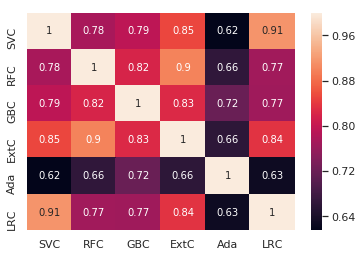

In [81]:
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_LRC = pd.Series(gsLRC_best.predict(test), name="LRC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_SVMC,test_Survived_RFC,test_Survived_GBC,
                              test_Survived_ExtC,test_Survived_AdaC,test_Survived_LRC],axis=1)
g= sns.heatmap(ensemble_results.corr(),annot=True)

저자와 마찬가지로 AdaBoost를 다른 분류기와 비교했을 때를 제외하면 6개 분류기에서는 예측이 상당히 비슷한 것으로 보입니다.<br>
6개의 분류자들은 거의 같은 예측을 하지만 약간의 차이가 있습니다.<br>
6개 분류자 예측 간의 논제 차이는 합당한 투표를 고려하기에 충분합니다.

[목차로](#0)
<a id="18"></a> <br>
### 6.2 Ensemble modeling
#### 6.2.1 Combining models

저자는 6개 분류기에서 나오는 예측을 결합하기 위해 투표 분류기를 선택했습니다.

각 투표의 확률을 고려하기 위해 "부드러운" 주장을 투표 매개변수에 전달하는 것을 선호했습니다.

In [82]:
votingC = VotingClassifier(estimators=[('svc',SVMC_best),('rfc',RFC_best),('gbc',GBC_best),
                                       ('extc',ExtC_best),('adac',ada_best),('LRC', gsLRC_best)],
                           voting='soft', n_jobs=4)
votingC = votingC.fit(X_train, Y_train)

[목차로](#0)
<a id="19"></a> <br>
### 6.3 Prediction
#### 6.3.1 Predict and Submit results

In [83]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")
results = pd.concat([IDtest,test_Survived],axis=1)
results.to_csv("ensemble_python_voting.csv",index=False)

저자 말 : 만약 당신이 이 공책을 유용하다고 생각하거나 좋아한다면, 몇몇 투표자들은 매우 감사할 것이고, 나에게도 동기부여가 될 것입니다. :)